In [ ]:
import os
import pandas as pd
import numpy as np

# ——————————————
# 配置参数
# ——————————————
fs_emg       = 1259                 # sEMG 采样率 (Hz)
fs_label     = 50                   # 疲劳标签采样率 (Hz)

subjects     = ['subject_1', 'subject_2', 'subject_3']
emg_root     = 'sEMG_data'  # sEMG 数据根目录，内含 subject_x/*.csv
lbl_root     = 'self_perceived_fatigue_index'
out_root     = 'aligned'    # 对齐后、归一化后保存目录

# ——————————————
# 主流程
# ——————————————
for subject in subjects:
    print(f"\n=== Processing {subject} ===")

    # 1) 读取并计算 MVC RMS 字典
    mvc_dir = f'sEMG_data/{subject}/MVC'
    rms_dict = {}
    for fname in sorted(os.listdir(mvc_dir)):
        if not fname.lower().endswith('.csv'): 
            continue
        df = pd.read_csv(os.path.join(mvc_dir, fname))
        # 定位“滑动 RMS”列
        rms_cols = [c for c in df.columns if 'FilterSlidingRMS' in c]
        if not rms_cols:
            continue
        col = rms_cols[0]
        sig = df[col]
        nonzero = sig[sig != 0]
        if nonzero.empty:
            val = 0.0
        else:
            trimmed = sig.loc[nonzero.index[0]: nonzero.index[-1]]
            val = np.sqrt((trimmed**2).mean())
        # 从文件名提取肌肉键名： subject_x_MVC_L_BICEPS.csv → L_BICEPS
        key = '_'.join(fname.replace('.csv','').split('_')[2:]).upper()
        rms_dict[key.replace('MVC_','')] = val
        print(f"  MVC {key}: RMS = {val:.2e}")

    # 2) 对齐 & 归一化 sEMG
    emg_dir = os.path.join(emg_root, subject)
    lbl_dir = os.path.join(lbl_root, subject)
    out_dir = os.path.join(out_root, subject)
    os.makedirs(out_dir, exist_ok=True)

    for fname in sorted(os.listdir(emg_dir)):
        if not fname.lower().endswith('.csv'):
            continue

        # 2.1 读取 sEMG + 时间戳
        emg_df = pd.read_csv(os.path.join(emg_dir, fname))
        emg_df['time'] = emg_df.index / fs_emg

        # 2.2 选取第 2,4,6,8 列 + time
        cols = [emg_df.columns[i] for i in (1,3,5,7)] + ['time']
        emg_sel = emg_df[cols].copy()

        # 2.3 按 MVC RMS 做 %MVC 归一化
        for col in cols:
            if col == 'time':
                continue
            # 原始列名 -> R_BICEPS_BRACHII
            raw = col.split(':')[0].strip().replace(' ', '_').upper()
            # 直接匹配
            if raw in rms_dict:
                key = raw
            else:
                # 模糊：取 side 和第一个肌肉词（BICEPS / DELTOID）
                side = raw.split('_')[0]
                muscle = raw.split('_')[1]
                # print(side,muscle)
                # 在 rms_dict 中找包含侧和肌肉词的键
                matches = [k for k in rms_dict if k.startswith(side) and muscle in k]
                if not matches:
                    raise KeyError(f"[{subject}] 无法匹配 RMS 键: {raw}")
                key = matches[0]
            emg_sel[col] = emg_sel[col] / rms_dict[key]

        # 2.4 读取标签，裁剪到 sEMG 时间范围
        lbl_df = pd.read_csv(os.path.join(lbl_dir, fname))
        lbl_df['time'] = lbl_df.index / fs_label
        tmax = emg_sel['time'].max()
        lbl_df = lbl_df[lbl_df['time'] <= tmax][['time','label']].sort_values('time')

        # 2.5 上采样对齐 (零阶保持)
        aligned = pd.merge_asof(
            emg_sel.sort_values('time'),
            lbl_df,
            on='time',
            direction='backward'
        ).drop(columns='time')

        # 2.6 保存结果
        out_path = os.path.join(out_dir, fname)
        aligned.to_csv(out_path, index=False)
        print(f"  → {fname}: {aligned.shape[0]} rows saved")

print("\nDone.")


=== Processing subject_1 ===
  MVC MVC_L_BICEPS: RMS = 7.36e-05
  MVC MVC_L_DELTOID_ANTERIOR: RMS = 1.85e-04
  MVC MVC_L_DELTOID_MEDIUS: RMS = 5.08e-05
  MVC MVC_L_DELTOID_POSTERIOR: RMS = 5.09e-05
  MVC MVC_R_BICEPS: RMS = 1.36e-04
  MVC MVC_R_DELTOID_ANTERIOR: RMS = 1.96e-04
  MVC MVC_R_DELTOID_MEDIUS: RMS = 9.20e-05
  MVC MVC_R_DELTOID_POSTERIOR: RMS = 1.00e-04
  → trial_1.csv: 120450 rows saved
  → trial_10.csv: 718854 rows saved
  → trial_11.csv: 508791 rows saved
  → trial_12.csv: 375121 rows saved
  → trial_2.csv: 141029 rows saved
  → trial_3.csv: 1023730 rows saved
  → trial_4.csv: 881388 rows saved
  → trial_5.csv: 225225 rows saved
  → trial_6.csv: 266127 rows saved
  → trial_7.csv: 143263 rows saved
  → trial_8.csv: 150407 rows saved
  → trial_9.csv: 443179 rows saved

=== Processing subject_2 ===
  MVC MVC_L_BICEPS: RMS = 1.07e-04
  MVC MVC_L_DELTOID_ANTERIOR: RMS = 2.21e-04
  MVC MVC_L_DELTOID_MEDIUS: RMS = 1.02e-04
  MVC MVC_L_DELTOID_POSTERIOR: RMS = 8.80e-05
  MVC MVC

In [18]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt

# ——————————————
# 配置参数
# ——————————————
fs_emg     = 1259           # sEMG 采样率 (Hz)
lowcut     = 20             # 带通下限 (Hz)
highcut    = 450            # 带通上限 (Hz)
order      = 4              # 滤波器阶数

subjects   = ['subject_1', 'subject_2', 'subject_3']
in_root    = 'aligned'    # 已对齐并归一化的数据目录
out_root   = 'filtered'   # 滤波后数据保存目录

# 设计 Butterworth 带通滤波器
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

b, a = butter_bandpass(lowcut, highcut, fs_emg, order)

# ——————————————
# 批量读取、滤波、保存
# ——————————————
for subject in subjects:
    in_dir  = os.path.join(in_root, subject)
    out_dir = os.path.join(out_root, subject)
    os.makedirs(out_dir, exist_ok=True)
    
    for fname in sorted(os.listdir(in_dir)):
        if not fname.lower().endswith('.csv'):
            continue
        
        # 1) 读取已对齐、归一化的数据
        df = pd.read_csv(os.path.join(in_dir, fname))
        
        # 2) 识别 EMG 通道（排除 'label' 列）
        emg_cols = [c for c in df.columns if c.lower() != 'label']
        
        # 3) 对每个通道应用 filtfilt 滤波
        filtered = df.copy()
        for ch in emg_cols:
            filtered[ch] = filtfilt(b, a, df[ch])
        
        # 4) 保存滤波后数据
        out_path = os.path.join(out_dir, fname)
        filtered.to_csv(out_path, index=False)
        print(f"[{subject}] {fname} → filtered saved ({len(filtered)} rows)")


[subject_1] trial_1.csv → filtered saved (120450 rows)
[subject_1] trial_10.csv → filtered saved (718854 rows)
[subject_1] trial_11.csv → filtered saved (508791 rows)
[subject_1] trial_12.csv → filtered saved (375121 rows)
[subject_1] trial_2.csv → filtered saved (141029 rows)
[subject_1] trial_3.csv → filtered saved (1023730 rows)
[subject_1] trial_4.csv → filtered saved (881388 rows)
[subject_1] trial_5.csv → filtered saved (225225 rows)
[subject_1] trial_6.csv → filtered saved (266127 rows)
[subject_1] trial_7.csv → filtered saved (143263 rows)
[subject_1] trial_8.csv → filtered saved (150407 rows)
[subject_1] trial_9.csv → filtered saved (443179 rows)
[subject_2] trial_1.csv → filtered saved (207620 rows)
[subject_2] trial_10.csv → filtered saved (481722 rows)
[subject_2] trial_11.csv → filtered saved (419048 rows)
[subject_2] trial_12.csv → filtered saved (788654 rows)
[subject_2] trial_2.csv → filtered saved (154050 rows)
[subject_2] trial_3.csv → filtered saved (523411 rows)
[su

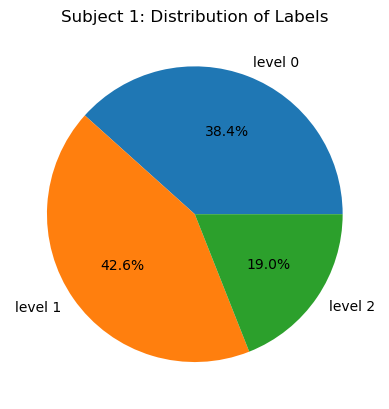

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

labels = []
fs_emg = 1259
window_size = fs_emg * 2

subject_list = ['subject_1','subject_2','subject_3']
for subject in subject_list:
    aligned_dir = f'aligned/{subject}'
    for fname in sorted(os.listdir(aligned_dir)):
        if not fname.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(aligned_dir, fname))
        n_windows = len(df) // window_size
        for i in range(n_windows):
            window = df.iloc[i*window_size:(i+1)*window_size]
            labels.append(window['label'].iloc[-1])

counts = pd.Series(labels).value_counts().sort_index()

plt.figure()
plt.pie(counts.values, labels=[f'level {int(l)}' for l in counts.index], autopct='%1.1f%%')
plt.title('Subject 1: Distribution of Labels')
plt.ylabel('')
plt.show()
